# MATH 2071 Lab 2 - Explicit ODE methods

Matthew Ragoza

2022-01-19

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exercise 1 - Forward Euler's method

The purpose of this exercise is to apply Euler's method to compute a numerical solution to an initial value problem for an explicit, scalar, first-order ODE:

$$
\begin{align}
y' &= f(x,y) \\
y(x_0) &= y_0
\end{align}
$$

Euler's method is the simplest possible algorithm for producing a numerical solution to an IVP. It computes the next value of $y$ iteratively based on the previous value and the derivative:

$$
\begin{align}
x_{k+1} &= x_k + h \\
y_{k+1} &= y_k + h y'(x_k, y_k)
\end{align}
$$

Since numerical solutions are approximations of exact solutions, we would also like to characterize how far off the approximation is from the exact solution.

To start off, I created a function that implements the forward Euler's method.

In [13]:
def forward_euler(f_ode, x_range, y_init, n_steps):
    
    # initialize arrays to store x and y values
    x = np.zeros(n_steps+1)
    y = np.zeros((n_steps+1, np.size(y_init)))
    
    # get the step size
    h = (x_range[1] - x_range[0]) / n_steps
    
    # compute numerical solution
    for k in range(0, n_steps+1):
        
        if k == 0: # set initial conditions
            x[0] = x_range[0]
            y[0,:] = y_init
        else:
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h * f_ode(x[k-1], y[k-1])

    return x, y

I also created functions for the righthand side of the following sample ODE initial value problem:

$$
\begin{align}
    y' &= -y - 3x\\
    y(0) &= 1
\end{align}
$$

And its exact solution:

$$
    y = -2e^{-x} -3x +3
$$

In [11]:
# sample ODE righthand side
def expm_ode(x, y):
    return -y - 3*x

# exact solution to sample ODE
def expm_exact(x):
    return -2*np.exp(-x) - 3*x + 3

Next, I used `forward_euler` to compute numerical solutions for the sample ODE with initial conditions $y_0 = 1.0$ on the $x$ range $[0, 2]$. I computed the solution using 6 different step sizes. I stored the numerical solution at $\hat{y}(2)$ for each step size, and I computed the error of the numerical solution $\hat{y}(2) - y(2)$ using the known exact solution.

I also computed error ratios between numerical solutions with consecutive step sizes.

,n_steps,step_size,y_euler,e_euler,r_euler
k,,,,,
0,10,0.20000,-3.214748,0.055922,2.032259
1,20,0.10000,-3.243153,0.027517,2.016470
2,40,0.05000,-3.257024,0.013646,2.008292
3,80,0.02500,-3.263876,0.006795,2.004157
4,160,0.01250,-3.267280,0.003390,2.002081
5,320,0.00625,-3.268977,0.001693,NaN


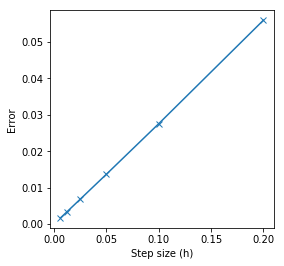

In [33]:
# create a table with the experiment parameters
df = pd.DataFrame(dict(
    n_steps=[10, 20, 40, 80, 160, 320],
    step_size=[0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625]
))
df.index.name = 'k'

# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = 1.0

# compute the numerical solutions
for k, n_steps in enumerate(df.n_steps):
    x, y = forward_euler(expm_ode, x_range, y_init, n_steps)
    df.loc[k, 'y_euler'] = y[-1]

# compute error and error ratios
df['e_euler'] = (df['y_euler'] - expm_exact(x=x_range[1]))
df['r_euler'] = df['e_euler'] / df['e_euler'].shift(-1)

# plot the errors wrt step size
plt.figure(figsize=(4,4))
plt.plot(df.step_size, df.e_euler, marker='x')
plt.xlabel('Step size (h)')
plt.ylabel('Error')

df # show the table

After plotting the errors with respect to the step size, a clear linear relationship is evident. A decrease in the step size results in a proportionate decrease in the error of the numerical solution.

We know that the numerical error scales according to $O(h^p)$ for some exponent $p$, which we call the *order of accuracy*. We can use the mean error ratio from the numerical experiment, in which we successively halved the step size, to estimate the order of accuracy.

In [64]:
# estimate p in error = O(h^p)
# i.e. the order of accuracy, an integer
p_euler = np.log2(df['r_euler'].mean())
p_euler

1.009097598339162

Using the forumla $p = log_2 \frac{error(h)}{error(h/2)}$, I arrived at an estimated order of accuracy of 1. This supports what I observed in the error plot, which is that the error has a linear relationship with the step size using the forward Euler's method. 

## Exercise 2 - Euler half-step (RK2) method

The next exercise explores another simple method for numerically solving an ODE called the Euler halfstep or RK2 method. The purpose is to demonstrate how a small algorithmic improvement can result in superior convergence behavior of the numerical solution.

The RK2 method first computes a Euler estimate of the point a half step foward (the midpoint between consecutive x points), then uses the derivative at this midpoint to estimate the full step.

$$
\begin{align}
x_a &= x_k + \frac{h}{2} \\
y_a &= y_k + \frac{h}{2} y'(x_k, y_k) \\
x_{k+1} &= x_k + h \\
y_{k+1} &= y_k + h y'(x_a, y_a)
\end{align}
$$

I extended the Euler's method function to compute a numerical solution using the RK2 method. I annotated the function signature and added comments and missing expressions for computing the auxiliary values.

In [27]:
def rk2(f_ode, x_range, y_init, n_steps):
    '''
    Compute a numerical solution to an ODE
    using the Euler half-step (RK2) method.
    
    Inputs:
        f_ode
            The righthand side of an ODE.
        x_range
            The min and max x value at which
            to compute the numerical solution.
        y_init
            The y value at the min x value.
        n_steps
            The number of steps to take to
            get across the x_range.
    Outputs:
        Two arrays of solution points x, y.
    '''
    # initialize arrays to store x and y values
    x = np.zeros(n_steps+1)
    y = np.zeros((n_steps+1, np.size(y_init)))
    
    # get the step size
    h = (x_range[1] - x_range[0]) / n_steps
    
    # compute numerical solution
    for k in range(0, n_steps+1):
        
        if k == 0: # set initial conditions
            x[0] = x_range[0]
            y[0,:] = y_init
        else:
            # the x and y coordinates a half-step forward
            x_a = x[k-1] + h/2
            y_a = y[k-1] + h/2 * f_ode(x[k-1], y[k-1])
            
            # use the halfstep derivative to estimate full step
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h * f_ode(x_a, y_a)

    return x, y

Just like before, I generated numerical solutions for the ODE with initial conditions $y_0 = 1.0$ on the $x$ range $[0, 2]$ with different 6 step sizes. However, this time I used the RK2 method instead of Euler's method.

I stored the numerical solution at $\hat{y}(2)$ for each step size, and I computed the error of the numerical solution $\hat{y}(2) - y(2)$ using the known exact solution.

I also computed error ratios between numerical solutions with consecutive step sizes.

,n_steps,step_size,y_rk2,e_rk2,r_rk2
k,,,,,
0,10,0.20000,-3.274896,0.004225,4.336740
1,20,0.10000,-3.271645,0.000974,4.158771
2,40,0.05000,-3.270905,0.000234,4.077143
3,80,0.02500,-3.270728,0.000057,4.038030
4,160,0.01250,-3.270685,0.000014,4.018882
5,320,0.00625,-3.270674,0.000004,NaN


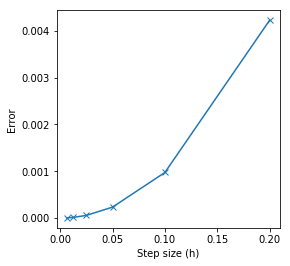

In [138]:
# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = 1.0

# compute the numerical solutions
for k, n_steps in enumerate(df.n_steps):
    x, y = rk2(expm_ode, x_range, y_init, n_steps)
    df.loc[k, 'y_rk2'] = y[-1]

# compute error and error ratios
df['e_rk2'] = (df['y_rk2'] - expm_exact(x=x_range[1])).abs()
df['r_rk2'] = df['e_rk2'] / df['e_rk2'].shift(-1)

# plot the errors wrt step size
plt.figure(figsize=(4,4))
plt.plot(df.step_size, df.e_rk2, marker='x')
plt.xlabel('Step size (h)')
plt.ylabel('Error')

df[['n_steps', 'step_size', 'y_rk2', 'e_rk2', 'r_rk2']] # show the table

This time, the plot of errors with respect to step size revealed a nonlinear relationship. It appears to have a parabolic shape, which would imply a quadratic relationship between step size and numerical error when using the RK2 method.

In [63]:
# estimate p in error = O(h^p)
# i.e. the order of accuracy, an integer
p_rk2 =np.log2(df['r_rk2'].mean())
p_rk2

2.044713382070369

I used the error ratios to estimate the order of accuracy for the RK2 method. The estimated order of 2 supports that the error of the RK2 method follows a quadratic relationship with the step size.

,n_steps,step_size,e_euler,e_rk2
k,,,,
0,10,0.20000,0.055922,0.004225
1,20,0.10000,0.027517,0.000974
2,40,0.05000,0.013646,0.000234
3,80,0.02500,0.006795,0.000057
4,160,0.01250,0.003390,0.000014
5,320,0.00625,0.001693,0.000004


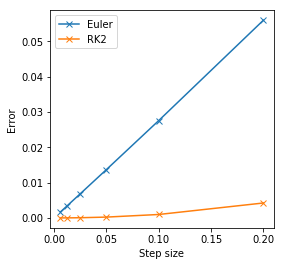

In [57]:
plt.figure(figsize=(4,4))
plt.plot(df.step_size, df.e_euler, label='Euler', marker='x')
plt.plot(df.step_size, df.e_rk2, label='RK2', marker='x')
plt.xlabel('Step size')
plt.ylabel('Error')
plt.legend()
df[['n_steps', 'step_size', 'e_euler', 'e_rk2']]

The table and plot above compare the error from using Euler's method compared with the RK2 method, for each of the different step sizes I evaluated. It is clear that the RK2 method converges faster than Euler as it achieves a much lower error at a given step size.

Euler's method would require roughly 120 steps to achieve comparable error as RK2 produces with only 10 steps, which is 0.004225.

Since the error in Euler's method has a linear relationship with step size, we can estimate the equation for a line from the collected data. The line will have an intercept of 0 since we know the series converges to the real function value as step size goes to zero. Therefore, we can simply estimate the slope as the mean ratio between error and step size.

In [125]:
# estimate the error scaling constant for Euler's method
c_euler = (df.e_euler / df.step_size).mean()
c_euler

0.2736156393667888

This produces an estimate $c = 0.2736$ for the error scaling constant. Now we can use this to estimate the step size needed to achieve a certain error rate using Euler's method via the equation $h= \frac{e}{c}$.

In [129]:
# estimate the step size needed to achieve a certain
#   error rate using Euler's method
# e = c h
# h = e/c
e_rk2 = df['e_rk2'].iloc[5]
h_euler = e_rk2 / c_euler

# convert step size to num steps
n_steps = int(2.0/h_euler)
n_steps

154544

After converting from step size to number of steps, we predict that Euler's method would require 154544 steps to attain the error rate that RK2 does using 320 steps. We can now run the `forward_euler` function to verify if we achieve this error rate.

In [131]:
# check that we achieve that error rate using Euler's method at 320 steps
x, y = forward_euler(expm_ode, x_range, y_init, n_steps=n_steps)
e_euler = y[-1,0] - expm_exact(x=x_range[1])
e_rk2, e_euler

(3.540941226010119e-06, 3.5028411202731036e-06)

Using 320 steps, RK2 has an error of 3.541e-6. Using 154,544 steps, Euler's method has an error of 3.503e-6. These errors are similar in magnitude, so our prediction was accurate.

# Exercise 3 - Runge-Kutta methods

This exercise has the goal of adding further complexity and performance to the ODE solvers we previously developed using higher-order Runge-Kutta methods.

$$
\begin{align}
    x_a &= x_k + \frac{h}{2} \\
    y_a &= y_k + \frac{h}{2} y'(x_k, y_k) \\
    x_b &= x_k + h \\
    y_b &= y_k + h (2y'(x_a, y_a) - y'(x_k, y_k)) \\
    x_{k+1} &= x_k + h \\
    y_{k+1} &= y_k + h(y'(x_k, y_k) + 4y'(x_a, y_a) + y'(x_b, y_b))/6.0
\end{align}
$$

In [132]:
def rk3(f_ode, x_range, y_init, n_steps):
    '''
    Compute a numerical solution to an ODE
    using the 3rd order Runge-Kutta method.
    
    Inputs:
        f_ode
            The righthand side of an ODE.
        x_range
            The min and max x value at which
            to compute the numerical solution.
        y_init
            The y value at the min x value.
        n_steps
            The number of steps to take to
            get across the x_range.
    Outputs:
        Two arrays of solution points x, y.
    '''
    # initialize arrays to store x and y values
    x = np.zeros(n_steps+1)
    y = np.zeros((n_steps+1, np.size(y_init)))
    
    # get the step size
    h = (x_range[1] - x_range[0]) / n_steps
    
    # compute numerical solution
    for k in range(0, n_steps+1):
        
        if k == 0: # set initial conditions
            x[0] = x_range[0]
            y[0,:] = y_init
        else:
            # the x and y coordinates a half-step forward
            x_a = x[k-1] + h/2
            y_a = y[k-1] + h/2 * f_ode(x[k-1], y[k-1])
            
            # additional intermediate step
            x_b = x[k-1] + h
            y_b = y[k-1] + h*(2*f_ode(x_a, y_a) - f_ode(x[k-1], y[k-1]))
            
            # use the halfstep derivative to estimate full step
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h*(
                f_ode(x[k-1], y[k-1]) + 4*f_ode(x_a, y_a) + f_ode(x_b, y_b)
            ) / 6

    return x, y

,n_steps,step_size,y_rk3,e_rk3,r_rk3
k,,,,,
0,10,0.20000,-3.270459,2.117936e-04,8.667036
1,20,0.10000,-3.270646,2.443669e-05,8.327000
2,40,0.05000,-3.270668,2.934632e-06,8.161776
3,80,0.02500,-3.270670,3.595581e-07,8.080446
4,160,0.01250,-3.270671,4.449730e-08,8.040126
5,320,0.00625,-3.270671,5.534404e-09,NaN


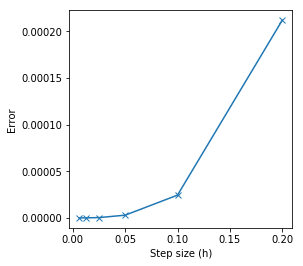

In [139]:
# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = 1.0

# compute the numerical solutions
for k, n_steps in enumerate(df.n_steps):
    x, y = rk3(expm_ode, x_range, y_init, n_steps)
    df.loc[k, 'y_rk3'] = y[-1]

# compute error and error ratios
df['e_rk3'] = (df['y_rk3'] - expm_exact(x=x_range[1])).abs()
df['r_rk3'] = df['e_rk3'] / df['e_rk3'].shift(-1)

# plot the errors wrt step size
plt.figure(figsize=(4,4))
plt.plot(df.step_size, df.e_rk3, marker='x')
plt.xlabel('Step size (h)')
plt.ylabel('Error')

df[['n_steps', 'step_size', 'y_rk3', 'e_rk3', 'r_rk3']] # show the table

In [140]:
# estimate p in error = O(h^p)
# i.e. the order of accuracy, an integer
p_rk3 = np.log2(df['r_rk3'].mean())
p_rk3

3.0453166068199478

,n_steps,step_size,e_rk2,e_rk3
k,,,,
0,10,0.20000,0.004225,2.117936e-04
1,20,0.10000,0.000974,2.443669e-05
2,40,0.05000,0.000234,2.934632e-06
3,80,0.02500,0.000057,3.595581e-07
4,160,0.01250,0.000014,4.449730e-08
5,320,0.00625,0.000004,5.534404e-09


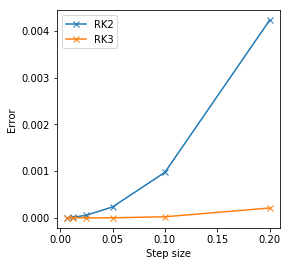

In [141]:
plt.figure(figsize=(4,4))
plt.plot(df.step_size, df.e_rk2, label='RK2', marker='x')
plt.plot(df.step_size, df.e_rk3, label='RK3', marker='x')
plt.xlabel('Step size')
plt.ylabel('Error')
plt.legend()
df[['n_steps', 'step_size', 'e_rk2', 'e_rk3']]

In [ ]:
# TODO more stuff

# Exercise 4 - Systems of equations

In [142]:
x = 1.0
y = np.array([5, 6])
f_val = expm_ode(x, y)
f_val

array([-8., -9.])

In [147]:
# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = np.array([5, 6])

# compute the numerical solution
xs, ys = rk3(expm_ode, x_range, y_init, n_steps=40)
ys[-1]

(2.000000000000001, array([-2.72933237, -2.59399855]))

In [149]:
x0, y0 = rk3(expm_ode, x_range, y_init=5, n_steps=40)
0y[-1]

array([-2.72933237])

In [150]:
x1, y1 = rk3(expm_ode, x_range, y_init=6, n_steps=40)
y1[-1]

array([-2.59399855])

# Exercise 5 - Pendulum ODE

# Exercise 6 - Comparisons?

# Exercise 7 - Adams-Bashforth methods